In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline 

bicycle = pd.read_csv('/gdrive/My Drive/dacon/bike/train.csv')
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [3]:
def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(bicycle.columns):
        missing_values = sum(bicycle[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

        if i == len(bicycle.columns) - 1 and counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')

check_missing_col(bicycle)

결측치가 존재하지 않습니다


In [4]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date_time:
        year_point, month_point, day_point = date.split('-')# - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(bicycle)
    
bicycle['year'] = year
bicycle['month'] = month
bicycle['day'] = day
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5


In [5]:
data_description = bicycle.describe()
data_description


,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,202.750967,2.288256,0.100963,2.480963,56.745491,13.795249,23.384733,16.878103,59574.978022,2019.000000,5.000000,15.670330
std,56.659232,0.961775,0.203193,0.884397,12.351268,5.107711,5.204605,16.643772,27659.575774,0.817996,0.813489,8.774195
min,57.047000,1.000000,0.000000,0.753000,24.831000,1.938000,9.895000,0.000000,1037.000000,2018.000000,4.000000,1.000000
25%,171.541000,1.405000,0.000000,1.820000,47.196000,9.938000,19.842000,4.054000,36761.000000,2018.000000,4.000000,8.000000
50%,209.774000,2.167000,0.000000,2.411000,55.845000,14.375000,24.158000,12.162000,63032.000000,2019.000000,5.000000,16.000000
75%,238.412000,3.000000,0.088000,2.924000,66.419000,18.000000,27.526000,22.973000,81515.000000,2020.000000,6.000000,23.000000
max,321.622000,4.000000,1.000000,5.607000,88.885000,22.312000,33.421000,82.162000,110377.000000,2020.000000,6.000000,31.000000


# EDA를 통해서 얻은 개인적인 직관

1) 의미 없는 Feature는 무엇인지?

직관적으로 생각을 했을 때, 자전거를 탈 때 바람의 방향을 중요하게 생각하는 사람은 많지 않을것이라고 생각

-> 상관계수를 통하여 검증 : 실제로 상관계수가 높지 않음


2) 1)을 기반으로하여 Feature Selection

->중요하지 않은 Feature로 간주한 'wind_direction' 보다 상관관계가 적은 Feature 역시 중요하지 않다고 가정


3) 영향이 간접적인 Feature

-> 실제로 자전거를 탈 때, 습도를 직접 고려하기보다 습도로 인한 기분 상태가 고려되기 때문에 습도를 불쾌지수로 연관지어 사용 

-> (정확하지 않지만) 불쾌지수를 고려하는 아이디어는 이전 다른 대회에서 제안 되었던 내용으로 알고 있습니다.

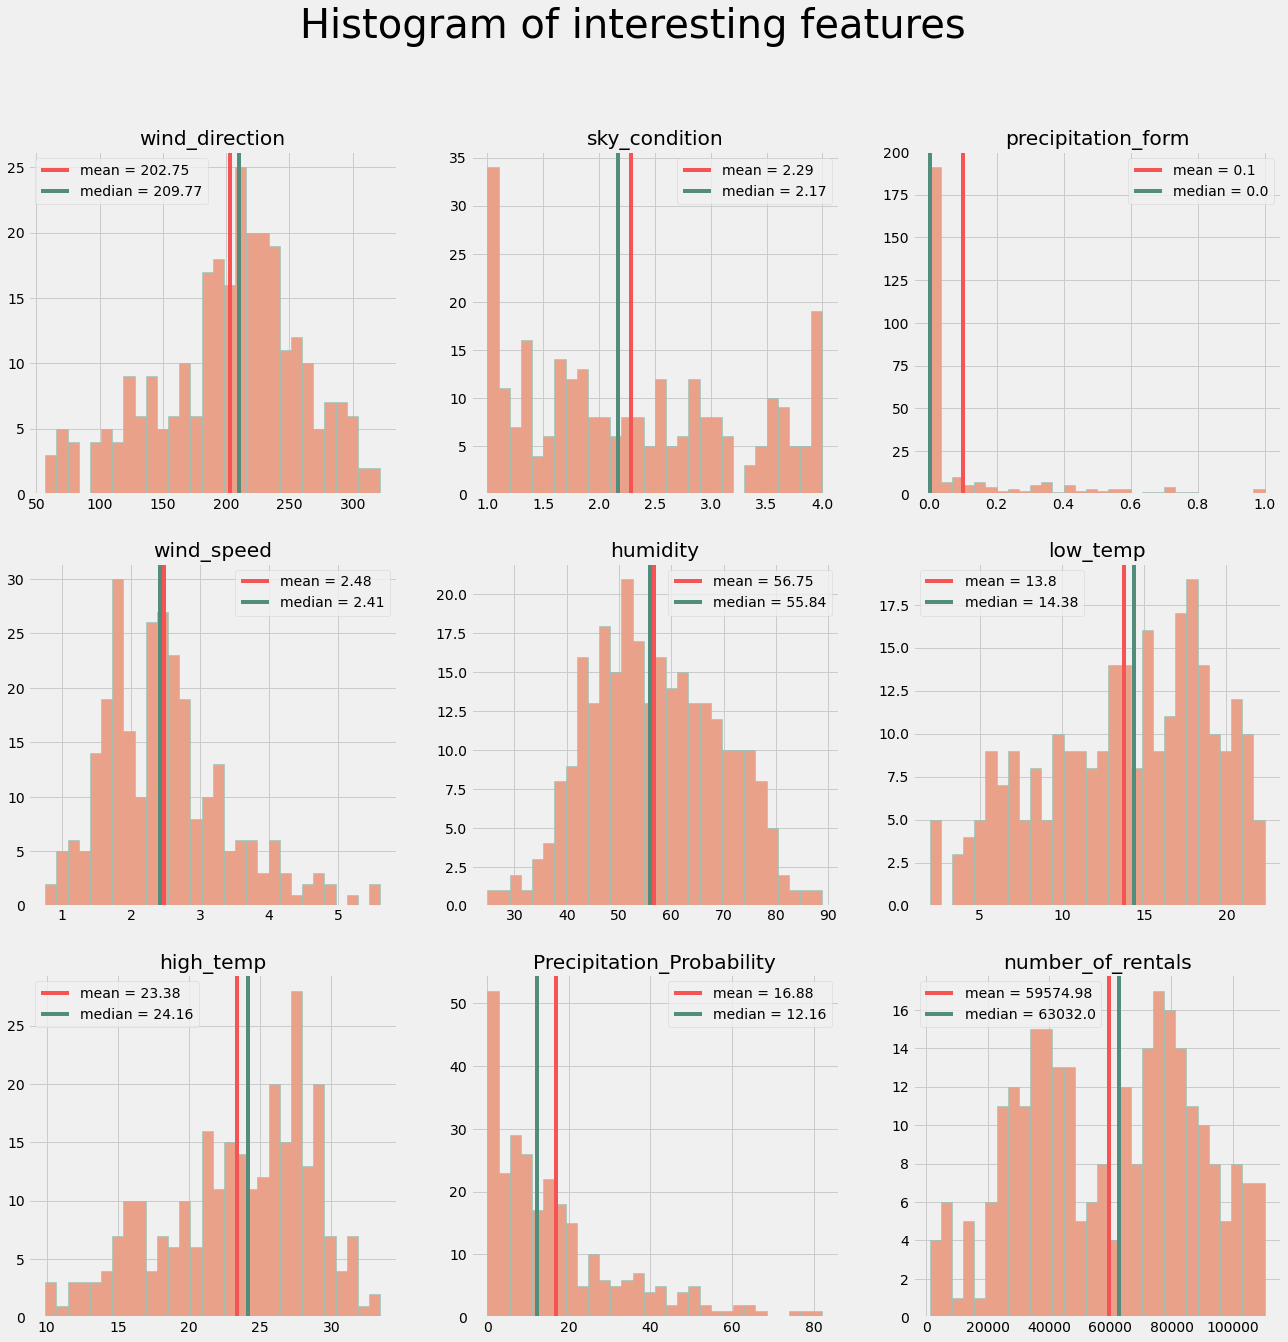

In [6]:
interest_coloumns = ['wind_direction', 'sky_condition', 'precipitation_form', 'wind_speed', 'humidity', 'low_temp', 'high_temp', 'Precipitation_Probability', 'number_of_rentals']

plt.style.use('fivethirtyeight')
fig, ax =plt.subplots(3, 3, figsize = (20, 20))
fig.suptitle('Histogram of interesting features', fontsize=40)

column_idx = 0
for i in range(3):
    for j in range(3):
        ax[i][j].hist(bicycle[interest_coloumns[column_idx]], bins=30, color='#eaa18a', edgecolor='#7bcabf')
        ax[i][j].set_title(interest_coloumns[column_idx])
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['mean'], c='#f55354', label = f"mean = {round(data_description[interest_coloumns[column_idx]]['mean'], 2)}")
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['50%'], c='#518d7d', label = f"median = {round(data_description[interest_coloumns[column_idx]]['50%'], 2)}")
        ax[i][j].legend()
        column_idx += 1

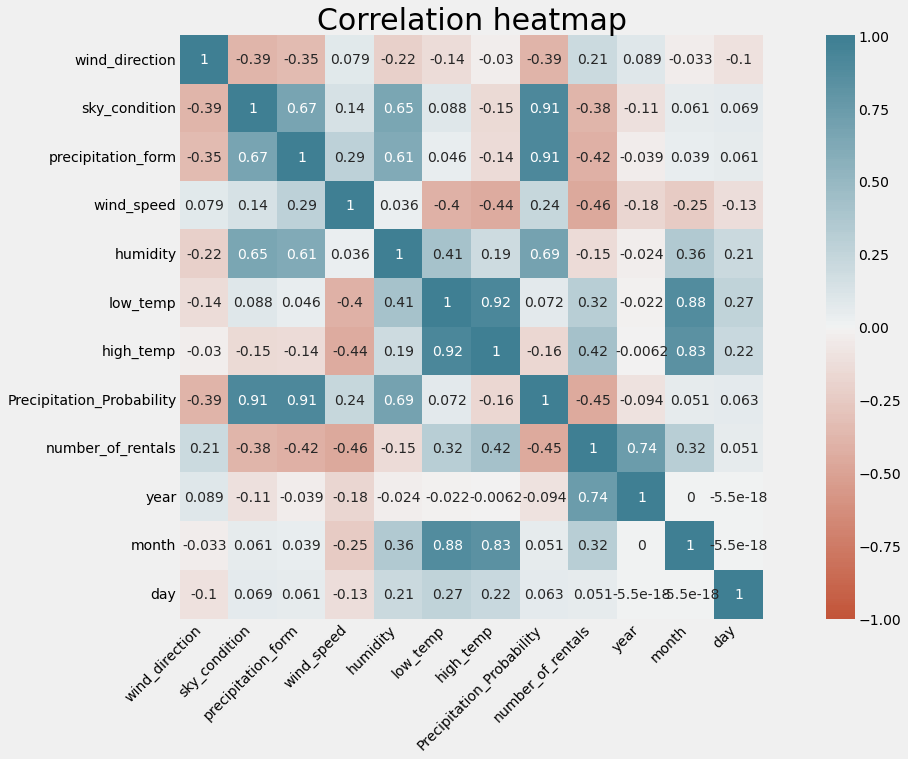

In [7]:
bicycle_number = bicycle.select_dtypes(np.number)#상관분석은 숫자로 계산할 수 있으므로 데이터에서 숫자로 이루어진 컬럼만을 뽑겠습니다 (date_time drop)

corr = bicycle_number.corr()
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Correlation heatmap', fontsize=30)
plt.show()

In [8]:
year_rentals = bicycle.groupby('year').sum()['number_of_rentals']
month_rentals = bicycle.groupby('month').sum()['number_of_rentals']
day_rentals = bicycle.groupby('day').sum()['number_of_rentals']

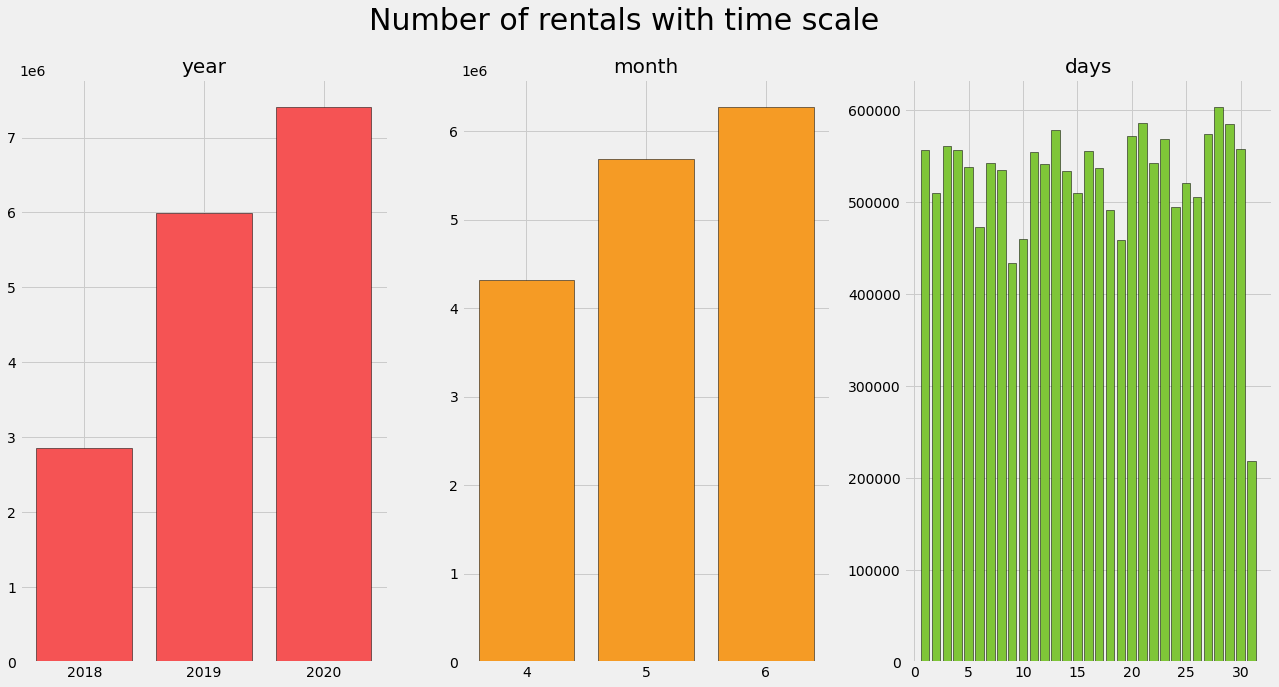

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Number of rentals with time scale', fontsize=30)

ax[0].bar(x=['2018', '2019', '2020'], height=year_rentals, color='#f55354', edgecolor='black')
ax[0].set_title('year', fontsize = 20)

ax[1].bar(x = ['4', '5', '6'], height=month_rentals, color='#f59b25', edgecolor='black')
ax[1].set_title('month', fontsize = 20)

ax[2].bar(x=day_rentals.index.to_list(), height= day_rentals, color='#7fc638', edgecolor='black')
ax[2].set_title('days', fontsize = 20)

plt.show()

In [10]:
week_day = pd.to_datetime(bicycle['date_time']).dt.day_name()
bicycle['week_day'] = week_day
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week_day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,Sunday
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,Monday
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,Tuesday
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,Wednesday
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,Thursday


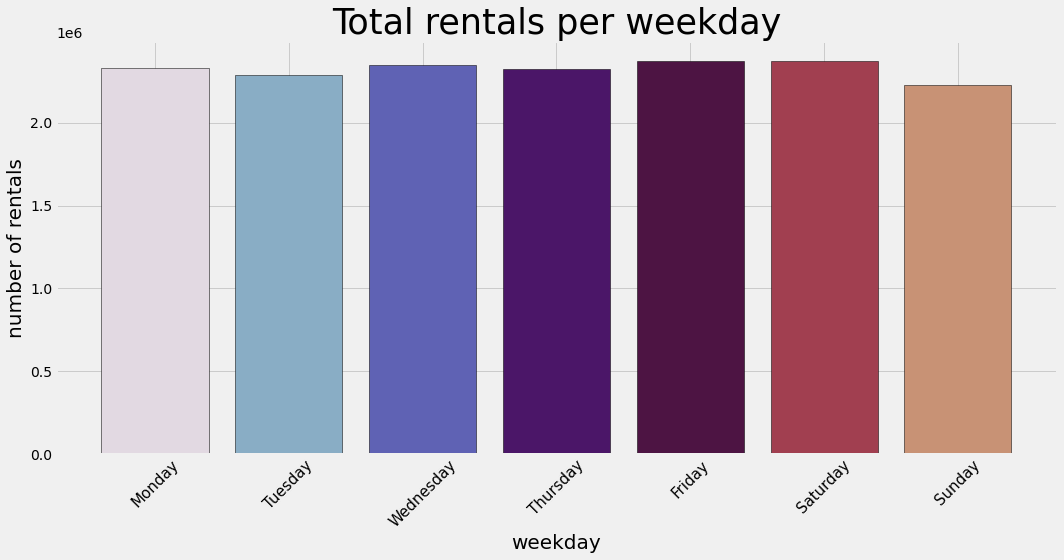

In [11]:
day_table = bicycle.groupby('week_day').sum()
day_table = day_table.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(15, 8))
color_map = plt.get_cmap('twilight')
color_list = [color_map.colors[i] for i in range(0, 512, 72)]
plt.bar(day_table.index, day_table.number_of_rentals, edgecolor='black', color=color_list)
plt.xticks(rotation=45, fontsize=15)
plt.title('Total rentals per weekday', fontsize=35)
plt.xlabel('weekday', fontsize=20)
plt.ylabel('number of rentals', fontsize=20)
plt.tight_layout()
plt.show()

직관적인 생각으로 데이터의 특징이 강수 확률 40을 기준으로 차이가 나는것 같음

-> 40을 기준으로 그룹화 수행

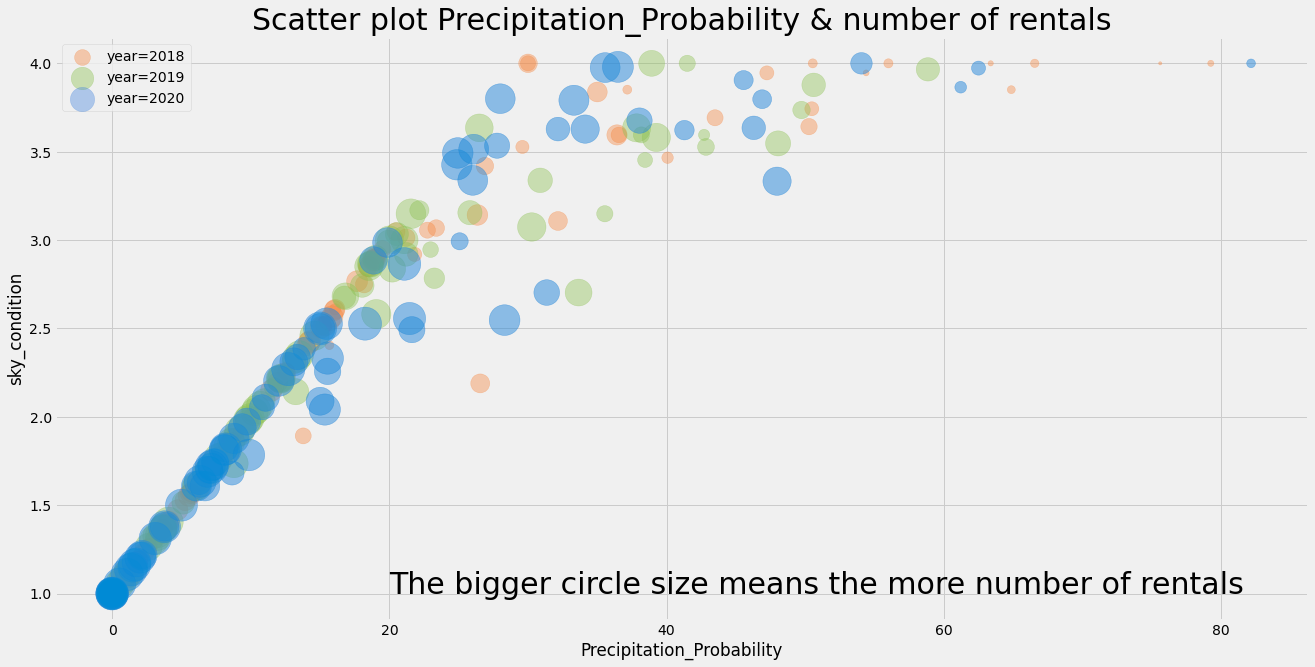

In [12]:
years = [2018, 2019, 2020]
colors = ['#f68842', '#8cc152', '#4a89df']

plt.figure(figsize=(20, 10))

for year, color in zip(years, colors):
    
    precipitation_prb = bicycle[bicycle['year'] == year].sort_values(by='Precipitation_Probability')['Precipitation_Probability']
    rentals = bicycle[bicycle['year'] == year].sort_values(by='Precipitation_Probability')['number_of_rentals']
    sky_condition = bicycle[bicycle['year'] == year].sort_values(by='Precipitation_Probability')['sky_condition']
    
    plt.scatter(precipitation_prb, sky_condition, s=rentals/100, alpha=0.4, c=color, label=f'year={year}')


plt.scatter(precipitation_prb, sky_condition,s=rentals/100, alpha=0.2)
plt.title('Scatter plot Precipitation_Probability & number of rentals', fontsize=30)
plt.xlabel('Precipitation_Probability')
plt.ylabel('sky_condition')
plt.text(20, 1.0, 'The bigger circle size means the more number of rentals', fontsize= 30)
plt.legend()
plt.show()

# 위에서 얻은 직관을 가지고 전처리 수행


In [13]:
#새로운 변수 추가
bicycle['Temperature'] = (bicycle['low_temp'] + bicycle['high_temp'])/2
bicycle['Feeling'] = (9/5)*bicycle['Temperature']-0.55*((100-bicycle['humidity'])/100)*((9/5)*bicycle['Temperature']-26)+32

# 그룹화
bicycle.loc[bicycle['Precipitation_Probability'] <40, 'Precipitation_Probability'] = 0
bicycle.loc[bicycle['Precipitation_Probability'] >=40, 'Precipitation_Probability'] = 1


# 필요 없다고 판단되는 정보 삭제
bicycle.drop(['date_time','humidity','wind_direction','week_day','day'], axis=1,  inplace=True)

In [14]:
bicycle

,sky_condition,precipitation_form,wind_speed,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,Temperature,Feeling
0,4.000,0.000,3.050,12.600,21.000,0.0,22994,2018,4,16.8000,61.657000
1,2.950,0.000,3.278,12.812,19.000,0.0,28139,2018,4,15.9060,60.194302
2,2.911,0.000,2.690,10.312,15.316,0.0,26817,2018,4,12.8140,55.470688
3,3.692,0.425,3.138,8.312,12.368,1.0,26034,2018,4,10.3400,51.755888
4,4.000,0.723,3.186,5.875,10.421,1.0,2833,2018,4,8.1480,48.300569
...,...,...,...,...,...,...,...,...,...,...,...
268,3.980,0.223,2.271,20.500,27.526,0.0,96150,2020,6,24.0130,73.175176
269,2.865,0.081,1.794,20.812,28.842,0.0,107001,2020,6,24.8270,74.469628
270,1.730,0.000,1.820,21.000,29.053,0.0,98568,2020,6,25.0265,74.191459
271,2.257,0.088,2.043,19.625,26.000,0.0,70053,2020,6,22.8125,70.616373


# model 학습

In [15]:
Y = bicycle['number_of_rentals']
X = bicycle.drop(['number_of_rentals'], axis=1)

In [16]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=3, random_state=0)
model.fit(X,Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

# 추론

In [17]:
test = pd.read_csv('/gdrive/My Drive/dacon/bike/test.csv')

In [18]:
year, month, day = seperate_datetime(test)
    
test['year'] = year
test['month'] = month
test['day'] = day
test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5


In [19]:
#새로운 변수 추가
test['Temperature'] = (test['low_temp'] + test['high_temp'])/2
test['Feeling'] = (5/9)*test['Temperature']-0.55*((100-test['humidity'])/100)*((5/9)*test['Temperature']-26)+32

# 그룹화
test.loc[test['Precipitation_Probability'] <40, 'Precipitation_Probability'] = 0
test.loc[test['Precipitation_Probability'] >=40, 'Precipitation_Probability'] = 1


# 필요 없다고 판단되는 정보 삭제
test.drop(['date_time','humidity','wind_direction','day'], axis=1,  inplace=True)

In [20]:
ans = model.predict(test)

In [21]:
submission = pd.read_csv('/gdrive/My Drive/dacon/bike/sample_submission.csv')
submission['number_of_rentals'] = ans

In [22]:
submission.to_csv('/gdrive/My Drive/dacon/bike/test_submission.csv', index= False)